In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from skimage import exposure
from skimage import feature
from skimage import restoration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Function to load and preprocess images
def load_and_preprocess_images(folder_path, image_size=(64, 64)):
    images = []
    labels = []
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        for file in os.listdir(label_path):
            file_path = os.path.join(label_path, file)
            img = cv2.imread(file_path)
            img = cv2.resize(img, image_size)

            # Convert to grayscale
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Normalize pixel values to [0, 1]
            img_gray = img_gray / 255.0

            # Histogram equalization
            img_equalized = exposure.equalize_hist(img_gray)

            # Denoising
            img_denoised = restoration.denoise_tv_chambolle(img_equalized, weight=0.1)

            images.append(img_denoised)
            labels.append(label)
    return np.array(images), np.array(labels)

In [ ]:
# Load and preprocess training and testing data
train_folder = '/content/drive/MyDrive/Colab Notebooks/Python_Project/Dataset_BUSI_with_GT/train'
test_folder = '/content/drive/MyDrive/Colab Notebooks/Python_Project/Dataset_BUSI_with_GT/test'

X_train, y_train = load_and_preprocess_images(train_folder)
X_test, y_test = load_and_preprocess_images(test_folder)

In [ ]:
# Flatten images for feature extraction
X_train_flatten = np.array([img.flatten() for img in X_train])
X_test_flatten = np.array([img.flatten() for img in X_test])

# Feature extraction using Local Binary Pattern (LBP)
def extract_lbp_features(images):
    lbp_features = []
    for img in images:
        features = feature.local_binary_pattern(img, P=8, R=1, method="uniform")
        lbp_hist, _ = np.histogram(features.ravel(), bins=np.arange(0, 10), range=(0, 9))
        lbp_features.append(lbp_hist)
    return np.array(lbp_features)

X_train_lbp = extract_lbp_features(X_train)
X_test_lbp = extract_lbp_features(X_test)

In [ ]:
# Concatenate LBP features with flattened images
X_train_combined = np.hstack((X_train_flatten, X_train_lbp))
X_test_combined = np.hstack((X_test_flatten, X_test_lbp))

# Split the data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_combined, y_train, test_size=0.2, random_state=42
)

In [ ]:
# Machine Learning Algorithms
svm_classifier = SVC()
knn_classifier = KNeighborsClassifier()
rf_classifier = RandomForestClassifier(random_state=42)

In [ ]:
# Train the classifiers
svm_classifier.fit(X_train_split, y_train_split)
knn_classifier.fit(X_train_split, y_train_split)
rf_classifier.fit(X_train_split, y_train_split)

RandomForestClassifier(random_state=42)

In [ ]:
# Predictions on the validation set
y_val_pred_svm = svm_classifier.predict(X_val_split)
y_val_pred_knn = knn_classifier.predict(X_val_split)
y_val_pred_rf = rf_classifier.predict(X_val_split)

In [ ]:
# Evaluate the models on the validation set
accuracy_svm = accuracy_score(y_val_split, y_val_pred_svm)
accuracy_knn = accuracy_score(y_val_split, y_val_pred_knn)
accuracy_rf = accuracy_score(y_val_split, y_val_pred_rf)

In [ ]:
print(f"SVM Accuracy: {accuracy_svm:.2f}")
print(f"KNN Accuracy: {accuracy_knn:.2f}")
print(f"RandomForest Accuracy: {accuracy_rf:.2f}")

SVM Accuracy: 0.46
KNN Accuracy: 0.64
RandomForest Accuracy: 0.82


In [ ]:
# Choose the classifier with the highest accuracy
classifiers = {'SVM': svm_classifier, 'KNN': knn_classifier, 'RandomForest': rf_classifier}
best_accuracy = 0
best_classifier_name = ""

for name, classifier in classifiers.items():
    # Predictions on the test set using the current classifier
    y_test_pred_current = classifier.predict(X_test_combined)

    # Evaluate the current classifier on the test set
    current_accuracy = accuracy_score(y_test, y_test_pred_current)
    print(f"Test Accuracy with {name}: {current_accuracy:.2f}")

    # Update the best classifier if the current one has higher accuracy
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        best_classifier_name = name

Test Accuracy with SVM: 0.44
Test Accuracy with KNN: 0.65
Test Accuracy with RandomForest: 0.85


In [ ]:
# Use the best classifier for predictions on the test set
best_classifier = classifiers[best_classifier_name]
y_test_pred_best = best_classifier.predict(X_test_combined)

# Evaluate the best classifier on the test set
test_accuracy = accuracy_score(y_test, y_test_pred_best)
print(f"Best Classifier: {best_classifier_name}")
print(f"Test Accuracy with {best_classifier_name}: {test_accuracy:.2f}")

# Classification report for the best classifier
print(f"Classification Report for {best_classifier_name}:")
print(classification_report(y_test, y_test_pred_best))

Best Classifier: RandomForest
Test Accuracy with RandomForest: 0.85
Classification Report for RandomForest:
              precision    recall  f1-score   support

      benign       0.75      0.80      0.77        30
    leukomia       1.00      0.97      0.98        31
   malignant       0.77      0.71      0.74        24
      normal       0.86      0.90      0.88        20

    accuracy                           0.85       105
   macro avg       0.84      0.84      0.84       105
weighted avg       0.85      0.85      0.85       105



In [ ]:
# Test the model on a user input image
def predict_user_input(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (64, 64))


    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


    img_gray = img_gray / 255.0


    img_equalized = exposure.equalize_hist(img_gray)


    img_denoised = restoration.denoise_tv_chambolle(img_equalized, weight=0.1)


    img_flatten = img_denoised.flatten()

    # Extract LBP features
    lbp_features = feature.local_binary_pattern(img_denoised, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp_features.ravel(), bins=np.arange(0, 10), range=(0, 9))

    # Concatenate LBP features with flattened image
    img_combined = np.hstack((img_flatten, lbp_hist))

    # Make a prediction
    prediction = best_classifier.predict([img_combined])

    # Display the input image and the predicted image
    plt.figure(figsize=(10, 5))

    # Input Image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Input Image")
    plt.axis("off")

    # Predicted Image
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {prediction[0]}")
    plt.axis("off")

    plt.show()

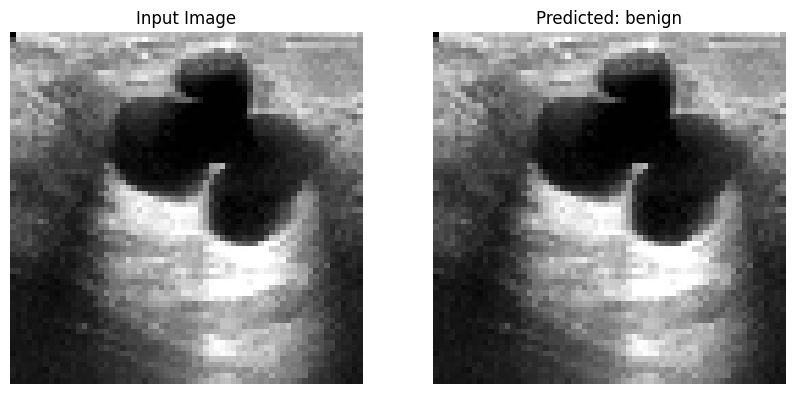

In [ ]:
# Example: Test the model on a user input image
user_input_image_path = '/content/drive/MyDrive/Colab Notebooks/DIP_project/Dataset_BUSI_with_GT (1)/test/benign/benign (152).png'
predict_user_input(user_input_image_path)

In [ ]:
from skimage import exposure, feature, restoration
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import joblib
# Save the trained classifier to a file
joblib.dump(best_classifier, 'our.pkl')

['our.pkl']